In [63]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tf_utils import load_features, random_mini_batches, convert_to_one_hot, predict

tf.logging.set_verbosity(tf.logging.ERROR)
# tf.logging.set_verbosity(tf.logging.INFO)

In [68]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 128, 28, 1])

    # Convolutional Layer #1
    #input shape [batch, 128, 28, 1]
    #output shape [batch, 128, 28, 80]    
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=80,
      kernel_size=[57, 6],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #1
    # Input Tensor Shape: [batch_size, 128, 28, 80]
    # Output Tensor Shape: [batch_size, 64, 14, 80]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2
    #input shape [batch_size, 64, 14, 80]
    #output shape [batch_size, 64, 14, 80]
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=80,
      kernel_size=[1, 3],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #2
    # Input Tensor Shape: [batch_size, 64, 14, 80]
    # Output Tensor Shape: [batch_size, 8, 2, 80]
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[8, 7], strides=[8, 7])

    # Flatten tensor
    # Input Tensor Shape: [batch_size, 8, 2, 80]
    # Output Tensor Shape: [batch_size, 8 * 2 * 80]
    pool2_flat = tf.reshape(pool2, [-1, 8 * 2 * 80])

    # Dense Layer
    dense1 = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

    # Add dropout operation; 0.6 probability that element will be kept
#     dropout1 = tf.layers.dropout(inputs=dense1, rate=0.5, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Dense Layer
    dense2 = tf.layers.dense(inputs=dense1, units=1024, activation=tf.nn.relu)

    # Add dropout operation; 0.6 probability that element will be kept
#     dropout2 = tf.layers.dropout(inputs=dense2, rate=0.5, training=mode == tf.estimator.ModeKeys.TRAIN)
    
    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 10]
    logits = tf.layers.dense(inputs=dense2, units=2)

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


Tensor("sparse_softmax_cross_entropy_loss/value:0", shape=(), dtype=float32)
Tensor("sparse_softmax_cross_entropy_loss/value:0", shape=(), dtype=float32)


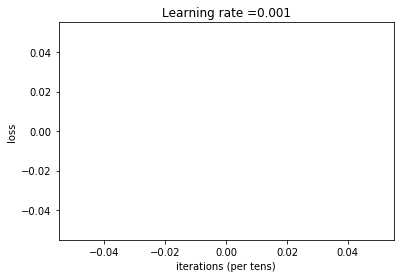

{'accuracy': 0.68472904, 'loss': 0.67006814, 'global_step': 300}


In [70]:
tf.reset_default_graph()
losses = []
learning_rate = 0.001

# Load training and eval data
train_data, eval_data, train_labels, eval_labels = load_features()
train_data = train_data.astype(np.float32)
eval_data = eval_data.astype(np.float32)    

# Create the Estimator
sound_classifier = tf.estimator.Estimator(
  model_fn=cnn_model_fn, model_dir="tmp/audio_convnet_model")

# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data}, y=train_labels, batch_size=1, num_epochs=None, shuffle=True
)
sound_classifier.train(input_fn=train_input_fn, steps=200)

# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
  x={"x": eval_data},
  y=eval_labels,
  num_epochs=1,
  shuffle=False)
eval_results = sound_classifier.evaluate(input_fn=eval_input_fn)

plt.plot(np.squeeze(losses))
plt.ylabel('loss')
plt.xlabel('iterations (per tens)')
plt.title("Learning rate =" + str(learning_rate))
plt.show()
    
print(eval_results)

In [55]:
def main(unused_argv):
    # Load training and eval data
    train_data, eval_data, train_labels, eval_labels = load_features()
    train_data = train_data.astype(np.float32)
    eval_data = eval_data.astype(np.float32)    
    
    # Create the Estimator
    sound_classifier = tf.estimator.Estimator(
      model_fn=cnn_model_fn, model_dir="tmp/audio_convnet_model")

    # Train the model
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={"x": train_data}, y=train_labels, batch_size=10, num_epochs=None, shuffle=True
    )
    sound_classifier.train(input_fn=train_input_fn, steps=100)
    
    # Evaluate the model and print results
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": eval_data},
      y=eval_labels,
      num_epochs=1,
      shuffle=False)
    eval_results = sound_classifier.evaluate(input_fn=eval_input_fn)
    print(eval_results)

if __name__ == "__main__":
    tf.reset_default_graph()
    tf.app.run()

ValueError: Dimension 0 in both shapes must be equal, but are 10 and 1. Shapes are [10,2] and [1,10]. for 'softmax_cross_entropy_with_logits_sg' (op: 'SoftmaxCrossEntropyWithLogits') with input shapes: [10,2], [1,10].

In [53]:
losses

[<tf.Tensor 'sparse_softmax_cross_entropy_loss/value:0' shape=() dtype=float32>,
 <tf.Tensor 'sparse_softmax_cross_entropy_loss/value:0' shape=() dtype=float32>]